<center> <h1> Noisy Encoder on Kaggle - Cats and Dogs Dataset </h1></center>

<h2> Import necessary utilities </h2>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch.optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from IPython import display

<h2> Set the device you will be using </h2>

<p> Note that the training will be significantly slower if you are using cpu </p>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

<h2> Preprocess the inputs </h2>

<b>Convert the images into numpy arrays</b>

In [3]:
# import os
# import cv2
# img_folder = 'Datasets\kagglecatsanddogs_5340\PetImages'
# labels = {'Cat': 0, 'Dog': 1}
# x = []
# y = []
# if not os.path.isdir(img_folder):
#     raise Exception('No such Directory')
# else:
#     for folder in os.listdir(img_folder):
#         folder_path = os.path.join(img_folder, folder)
#         for file in os.listdir(folder_path):
#             try:
#                 if file.endswith('.jpg'):
#                     file_path = os.path.join(folder_path, file)
#                     img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2GRAY)
#                     img = cv2.resize(img, (128, 128)) / 255
#     #                 print(img.shape)
#     #                 plt.imshow(img, cmap='gray')
#     #                 plt.show()
#                     x.append(img)
#                     y.append(labels[folder])
#             except:
#                 pass
# print(len(x))
# print(len(y))

<b>Save the numpy arrays into a file so that you can skip reading the images everytime</b>

In [4]:
# x , y = np.array(x), np.array(y)
# np.save('Datasets/128DogCats_X', x)
# np.save('Datasets/128DogCats_y', y)

<b>Load the numpy arrays</b>

In [5]:
x = np.load('Datasets/128DogCats_X.npy')

<h2>Split the data into train and test and visualize the images</h2>

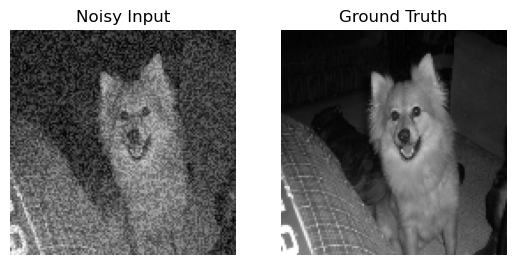

In [6]:
# Convert the numpy lists into tensors
x = torch.Tensor(x)

# Split the data into train and test 
train_x, test_x, train_y, test_y  = train_test_split(x, x, test_size=0.2, shuffle=True)

# Add noise to the Features
def add_noise(x, noise_lvl=0.40):
    """
    Add noise to the input features
    :param x: features
    :param noise_lvl: percentage of noise to be added
    :return: noisy features
    """
    noise = torch.rand_like(x) * noise_lvl
    x = x + noise
    return x


def plot_features():
    """Plot the Noisy Input and the Ground Truth"""
    plt.subplot(1, 2, 1)
    plt.imshow(test_x[0], cmap='gray')
    plt.axis('off')
    plt.title('Noisy Input')
    plt.subplot(1, 2, 2)
    plt.imshow(test_y[0], cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth')


train_x = add_noise(train_x)
test_x = add_noise(test_x)
plot_features()

<h2>Build the neural network</h2>

The depth of the network depends on the size of the images and the variations in the images

In [7]:
class Autoencoder(nn.Module):
    """Autoencoder with Skip Connections"""
    def __init__(self):
        """Initialize the Autoencoder"""
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 8*8*512),
            nn.LeakyReLU(),
            nn.Unflatten(1, (512, 8, 8))
        )
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid to ensure outputs are between 0 and 1
        )

    def forward(self, x):
        """Forward Pass of the Autoencoder"""
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        b = self.bottleneck(e4)
        d1 = self.dec1(b + e4)  # Adding skip connections
        d2 = self.dec2(d1 + e3)
        d3 = self.dec3(d2 + e2)
        d4 = self.dec4(d3 + e1)
        return d4
    
    def get_features(self, x):
        """Get the Bottleneck and the Final Output"""
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        b = self.bottleneck(e4)
        d1 = self.dec1(b + e4)  # Adding skip connections
        d2 = self.dec2(d1 + e3)
        d3 = self.dec3(d2 + e2)
        d4 = self.dec4(d3 + e1)
        return b, d4

<h2>Create an object of the model</h2>

In [8]:
model = Autoencoder().to(device)
model.eval()

Autoencoder(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_d

<h2>Load the weights of a pretrained model if present</h2>

Loading weights pretrained models will eliminate the need to train the model from scratch. 

In [9]:
model.load_state_dict(torch.load('models/NoisyAutoEncoder1.pth'))

<All keys matched successfully>

<h2>Initialize the weights for the model manually if you feel it is not converging to a minima</h2>
Pytorch initializations are fine most of the time

<h3>NOTE: Do not initialize the weights on a pretrained model</h3>

In [10]:
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
# model = model.apply(weights_init)

<h2>Define the hyperparameters to the Model</h2>

In [11]:
#  Define the Batch Size
batch_size = 500

# Total number of epochs to train
num_epochs = 500

#  Set the Loss function/criterion
loss_function = nn.BCELoss()

#  Set the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Use a scheduler to reduce learning rate
# scheduler = StepLR(optimizer, step_size=250, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

<h2>Create Some Functions that help in training the model as well as visualizing the outputs</h2>

In [12]:
def plot_images(inputs, bottlenecks, outputs):
    """
    Plot the Input Images, Bottleneck Outputs and the Final Outputs
    :param inputs: noisy inputs
    :param bottlenecks: bottleneck outputs
    :param outputs: final outputs
    """
    
#   Plot the Input Images  
    plt.figure(figsize=(20,200))
    for idx, image in enumerate(inputs):
        plt.subplot(1, 10, idx+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
#   Plot the Bottleneck Outputs      
    plt.figure(figsize=(20,200))
    for idx, image in enumerate(bottlenecks):
        image = np.resize(image, (10, 10))
        plt.subplot(1, 10, idx+1)
        plt.imshow(image, cmap='gray')   
        plt.axis('off')

#   Plot the Final Outputs
    plt.figure(figsize=(20,200))
    for idx, image in enumerate(outputs):
        plt.subplot(1, 10, idx+1)
        plt.imshow(image, cmap='gray')   
        plt.axis('off')


def visualize_outputs(model):
    """
    Visualize the Outputs of the Model
    :param model: autoencoder model
    """
#   Get 10 random images  
    r_list = [random.randint(0, len(test_x)-1) for i in range(10)]
    inputs = [test_x[i] for i in r_list]
    final_outputs = []
    bottleneck_outputs = []
#   Retrieve the Bottleneck Output and the Final Output for each image
    for single_input in inputs:
        with torch.no_grad():
            bottleneck, output = model.get_features(single_input.view(-1, 1, 128, 128).to(device))
            bottleneck = bottleneck.cpu().numpy()
            bottleneck = bottleneck.squeeze(0)
            bottleneck = np.transpose(bottleneck, (1, 2, 0))
            output = output.cpu().numpy()
            output = output.squeeze(0)
            output = np.transpose(output, (1, 2, 0))
            final_outputs.append(output)
            bottleneck_outputs.append(bottleneck)
    plot_images(inputs, bottleneck_outputs, final_outputs)
    plt.show()


def train(model, x, y, num_epochs, batch_size):
    """
    Train the model
    :param model: autoencoder model
    :param x: noisy inputs
    :param y: ground truth
    :param num_epochs: number of epochs the model is to be trained
    :param batch_size: size of mini batches to be used
    :return: 
    """
    for epoch in range(num_epochs):
        progress_bar = tqdm((0, len(x), batch_size), desc=f'Epoch {epoch+1}/{num_epochs}')
        
#       Train Batch_wise  
        for i in progress_bar:
            model.zero_grad()
            batch_x = x[i:i+batch_size]
            batch_x = batch_x.view(-1, 1, 128, 128).to(device)
            batch_y = y[i:i+batch_size].to(device)
            
#           Get the Output of the model
            output = model(batch_x)
    
#           Calculate the loss
            loss = loss_function(output, batch_y.view(-1, 1, 128, 128))
    
#           Backpropagate
            loss.backward()
            optimizer.step()
        
#           Set Loss values on the progress bar
            progress_bar.set_postfix({
                'Loss': loss.detach().cpu().item(),
            })
    
#     Uncomment the next line if you are using a scheduler
#         scheduler.step(loss)

#       Clear the outptut and visualize the ouputs every 25 epochs
        if epoch % 25 == 0:
            display.clear_output(wait=False)
            print(f"Epoch {epoch}/{num_epochs} - Loss: {loss}")
            visualize_outputs(model)
            
        
#  Display the Final Loss and visualise outputs
    else:
        display.clear_output(wait=False)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss}")
        visualize_outputs(model)


<h2>Train the Model</h2>

In [13]:
# train(
#     model=model,
#     x=train_x,
#     y=train_y,
#     num_epochs=num_epochs,
#     batch_size=batch_size
# )

<h2>Visualize the Outputs for a couple of times to ensure the model working as intended</h2>

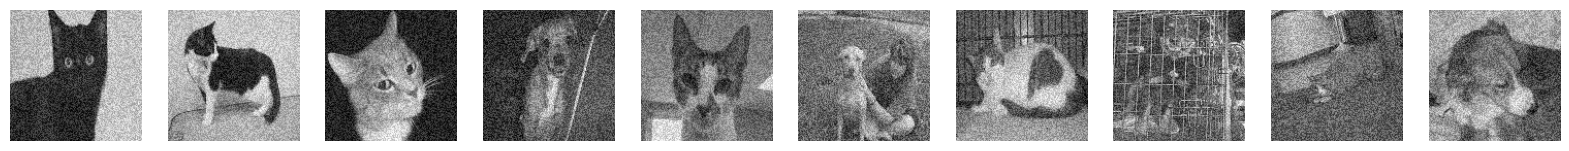

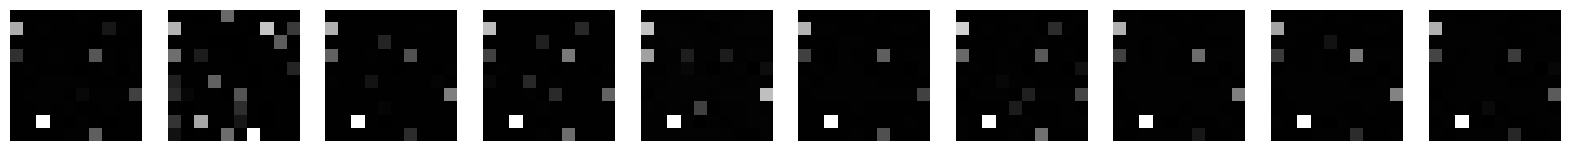

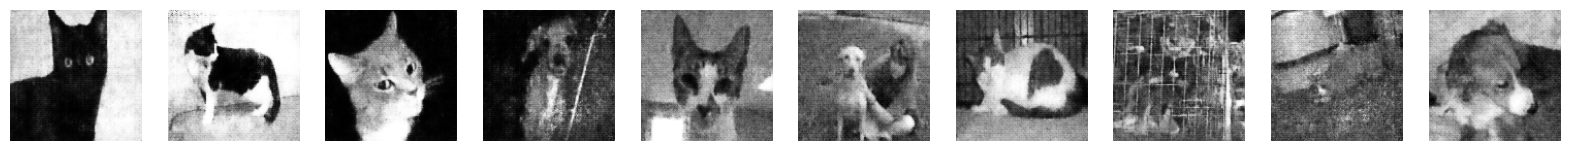

<Figure size 2000x20000 with 0 Axes>

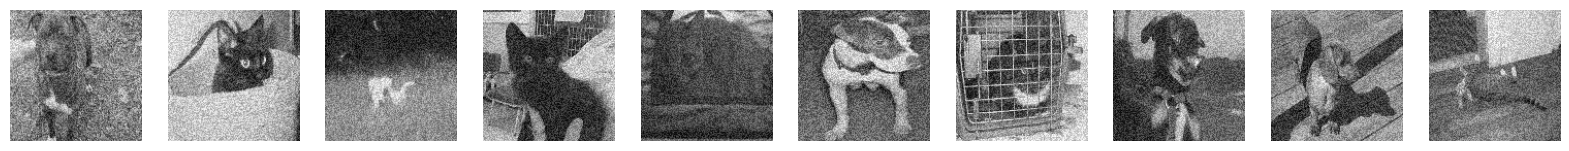

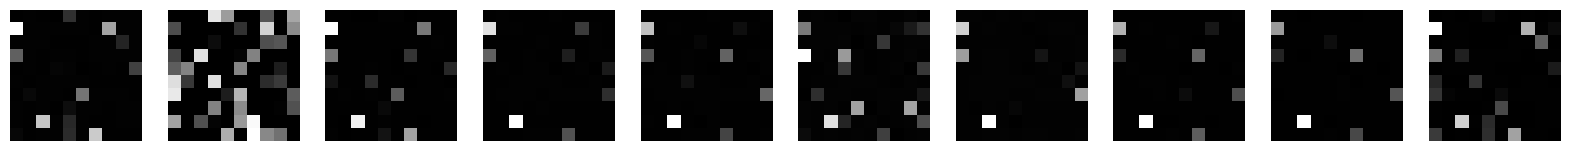

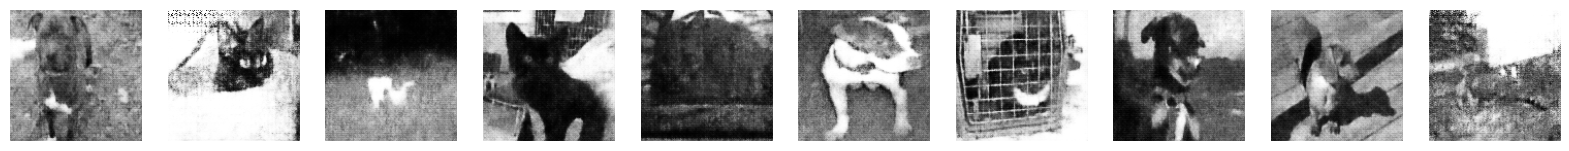

<Figure size 2000x20000 with 0 Axes>

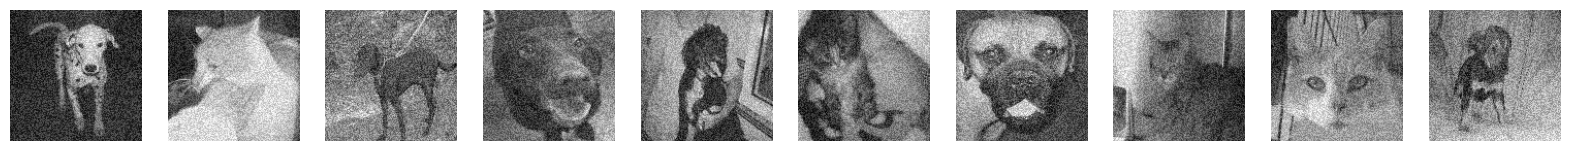

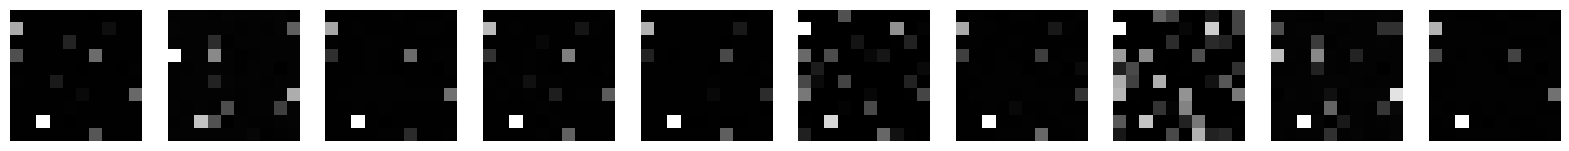

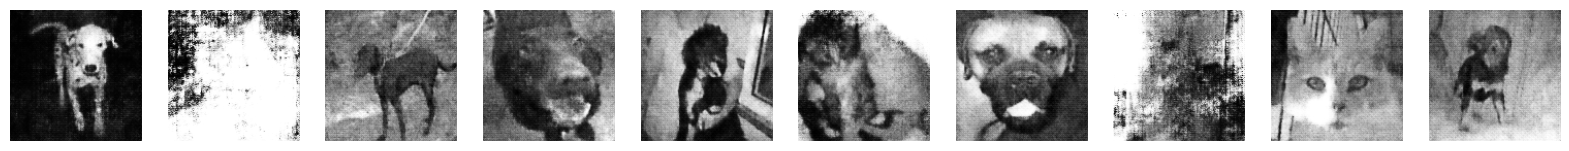

<Figure size 2000x20000 with 0 Axes>

In [14]:
for _ in range(3):
    visualize_outputs(model)
    plt.figure(figsize=(20, 200))

<h2>Save the model weights</h2>
These are the weights that can be loaded onto the model later if you want to fine-tune

In [15]:
# torch.save(model.state_dict(), 'models/NoisyAutoEncoder.pth')